# Wordnet (słowosieć)

The task concentrates on the usage of a WordNet for finding semantic relations between words and expressions.
## Task

### Read the [Wordnet API](http://api.slowosiec.clarin-pl.eu/docs/index.html)
### Get acquainted with [semantic relations](http://nlp.pwr.wroc.pl/narzedzia-i-zasoby/narzedzia/disaster/25-wiedza/81-relacje-w-slowosieci) in WordNet.

In [98]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt

In [296]:
base_url = "http://api.slowosiec.clarin-pl.eu/plwordnet-api/"

def get(url):
    full_url = base_url+url
    return json.loads(requests.get(url=full_url).content.decode('utf-8'))

def search_senses(lemma, part_of_speech = None):
    url = 'senses/search?lemma={}'.format(lemma)
    if part_of_speech is not None:
        url = '{}&&&partOfSpeech={}'.format(url, part_of_speech)
    return get(url)['content']

def sense_meaning(senses, number=1):
    for meaning in senses:
        if meaning["senseNumber"] == number:
            return meaning
    return None

def sysnet_from_sense(sense):
    url = 'senses/{}/synset'.format(sense["id"])
    return get(url)

def senses_from_sysnet(sysnet):
    url = 'synsets/{}/senses'.format(sysnet["id"])
    return get(url)

def sysnet_relations_to(sysnet):
    url = 'synsets/{}/relations/to'.format(sysnet["id"])
    return get(url)

def show_graph(edges, edgesLabels):
    G=nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(16, 16))
    node_sizes = [500 * len(node) for node in G.nodes._nodes.keys()]
    nx.draw(G, pos, edge_color='black', node_size=node_sizes, node_color='pink', labels={node:node for node in G.nodes()}, arrowsize=20, arrowstyle='fancy')
    nx.draw_networkx_edge_labels(G, pos, node_size=node_sizes, edge_labels=edgesLabels, font_color='red', arrowstyle='->')
    plt.show()

### Find all meanings of the _szkoda_ **noun** and display all their synonyms.

In [262]:
def zad_1():
    meanings = search_senses("szkoda", "noun")
    for meaning in meanings:
        description = meaning["domain"]["description"]
        lemma = meaning["lemma"]["word"]
        print('{}-{}:'.format(lemma, description))
        sysnet = sysnet_from_sense(meaning)
        synonyms = senses_from_sysnet(sysnet)
        for synonym in synonyms:
            print('  {}'.format(synonym["lemma"]["word"]))
        print()
zad_1()

szkoda-plWN miejsca i umiejscowienie:
  szkoda

szkoda-plWN posiadanie i jego zmiana:
  strata
  utrata
  szkoda
  uszczerbek



### Find closure of **hypernymy** relation for the first meaning of the _wypadek drogowy_ expression. Create diagram of the relations as a directed graph.

wypadek komunikacyjny -> wypadek drogowy
wypadek -> wypadek komunikacyjny
zdarzenie oceniane negatywnie -> wypadek
wydarzenie,historia,wypadek,zdarzenie -> zdarzenie oceniane negatywnie


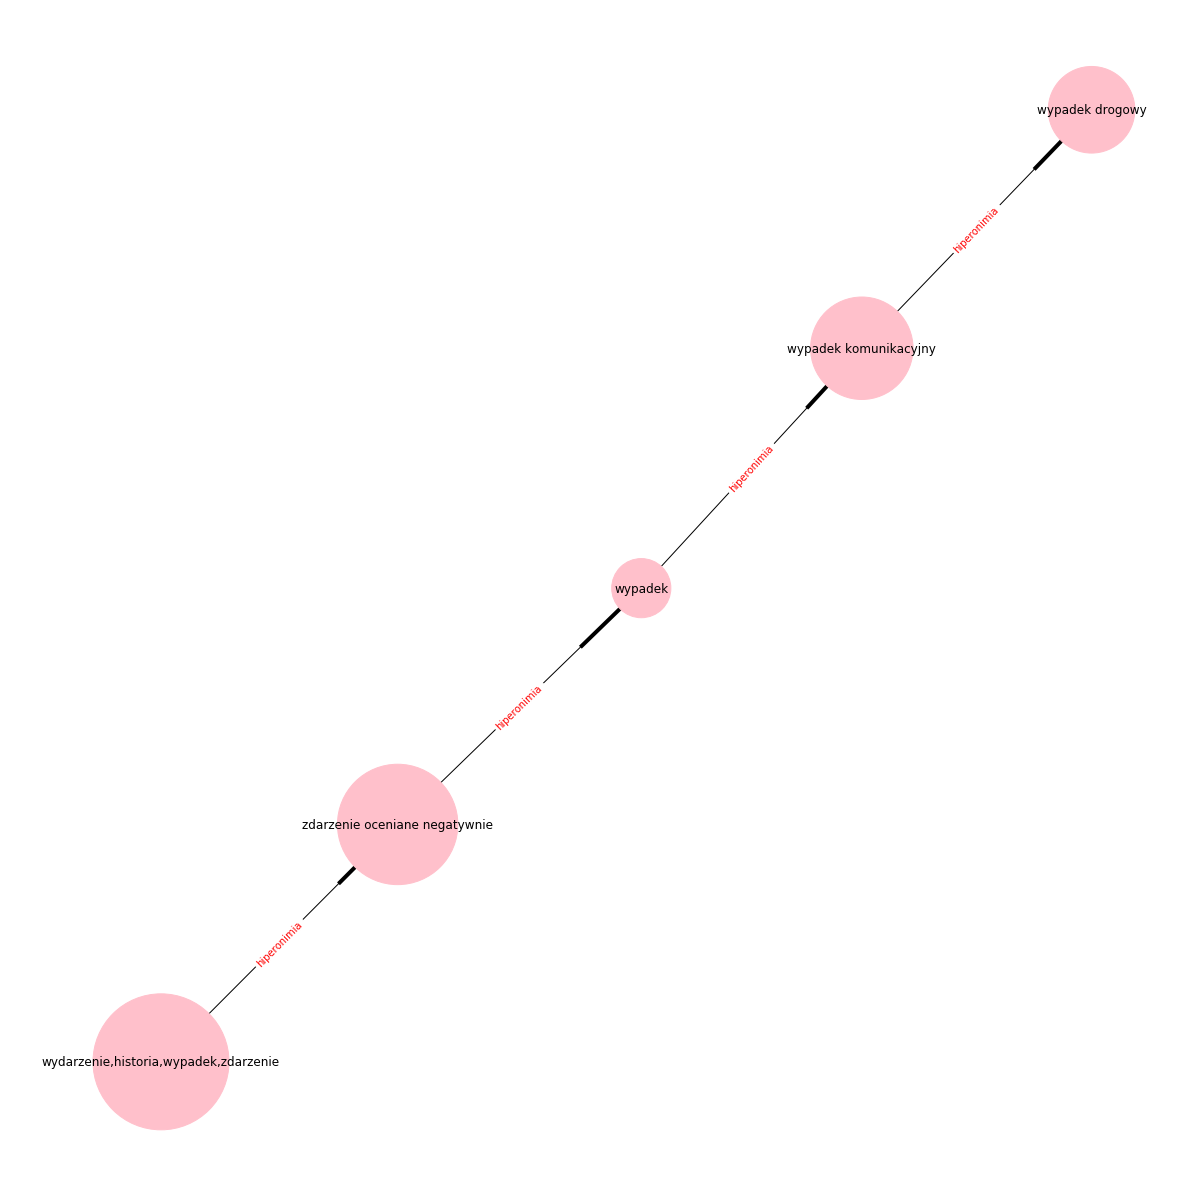

In [295]:
def add_hypernyms(sysnet, edges, edgesLabels):
    relations = sysnet_relations_to(sysnet)
    for hypernym in filter(lambda relation: relation['relation']['name'] == 'hiperonimia', relations):
        from_synset = hypernym['synsetFrom']
        from_name = ",".join(map(lambda sense: sense['lemma']['word'], senses_from_sysnet(from_synset)))
        to_synset = hypernym['synsetTo']
        to_name = ",".join(map(lambda sense: sense['lemma']['word'], senses_from_sysnet(to_synset)))
        print('{} -> {}'.format(from_name, to_name))
        edges.append([from_name, to_name])
        edgesLabels[(from_name, to_name)] = 'hiperonimia'
        add_hypernyms(from_synset, edges, edgesLabels)

def zad_2():
    edges=[]
    edgesLabels={}
    senses = search_senses("wypadek drogowy")
    meaning = sense_meaning(senses, 1)
    sysnet = sysnet_from_sense(meaning)
    add_hypernyms(sysnet, edges, edgesLabels)
    show_graph(edges, edgesLabels)
zad_2()

### Find direct **hyponyms** of _wypadek<sub>1</sub>_ noun.

1: zawał -> wypadek
1: tąpnięcie -> wypadek
1: katastrofa -> wypadek
1: wykolejenie -> wypadek
1: zakrztuszenie,zachłyśnięcie -> wypadek
1: wypadek komunikacyjny -> wypadek
1: katastrofa budowlana -> wypadek


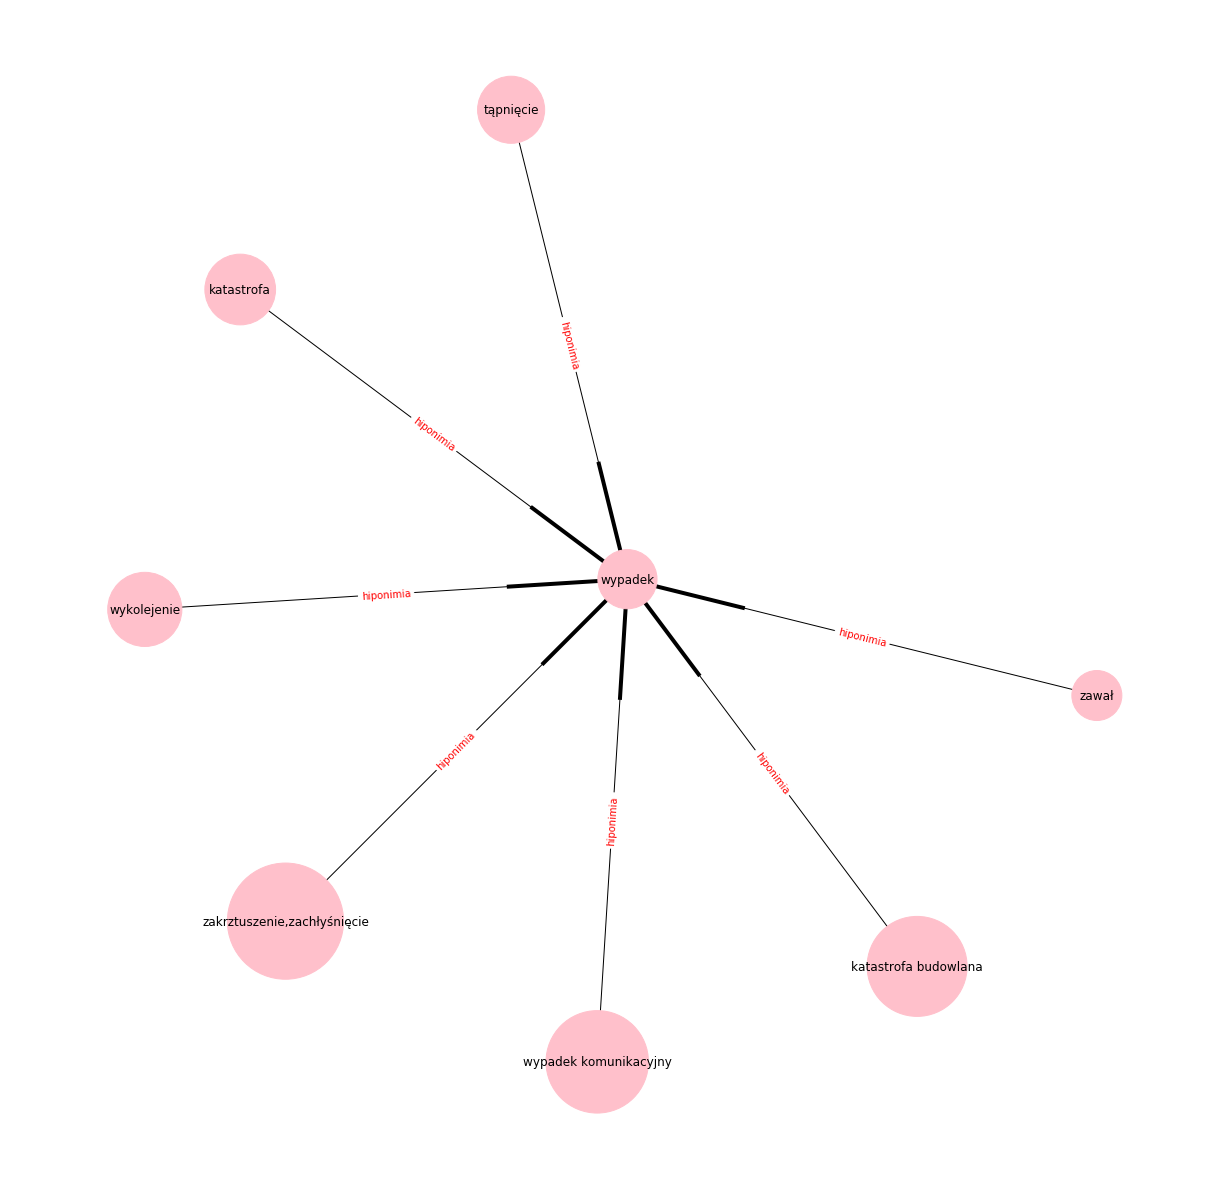

In [265]:
def add_hyponyms(sysnet, edges, edgesLabels, limit, depth):
    relations = sysnet_relations_to(sysnet)
    for hypernym in filter(lambda relation: relation['relation']['name'] == 'hiponimia', relations):
        from_synset = hypernym['synsetFrom']
        from_name = ",".join(map(lambda sense: sense['lemma']['word'], senses_from_sysnet(from_synset)))
        to_synset = hypernym['synsetTo']
        to_name = ",".join(map(lambda sense: sense['lemma']['word'], senses_from_sysnet(to_synset)))
        print('{}: {} -> {}'.format(depth, from_name, to_name))
        edges.append([from_name, to_name])
        edgesLabels[(from_name, to_name)] = 'hiponimia'
        if limit > depth:
            add_hyponyms(from_synset, edges, edgesLabels, limit, depth+1)

def zad_3():
    edges=[]
    edgesLabels={}
    senses = search_senses("wypadek", "noun")
    meaning = sense_meaning(senses, 1)
    sysnet = sysnet_from_sense(meaning)
    add_hyponyms(sysnet, edges, edgesLabels,1,1)
    show_graph(edges, edgesLabels)
zad_3()

### Find second-order **hyponyms** of the same noun.

1: zawał -> wypadek
2: obwał -> zawał
1: tąpnięcie -> wypadek
1: katastrofa -> wypadek
1: wykolejenie -> wypadek
1: zakrztuszenie,zachłyśnięcie -> wypadek
1: wypadek komunikacyjny -> wypadek
2: wypadek drogowy -> wypadek komunikacyjny
1: katastrofa budowlana -> wypadek


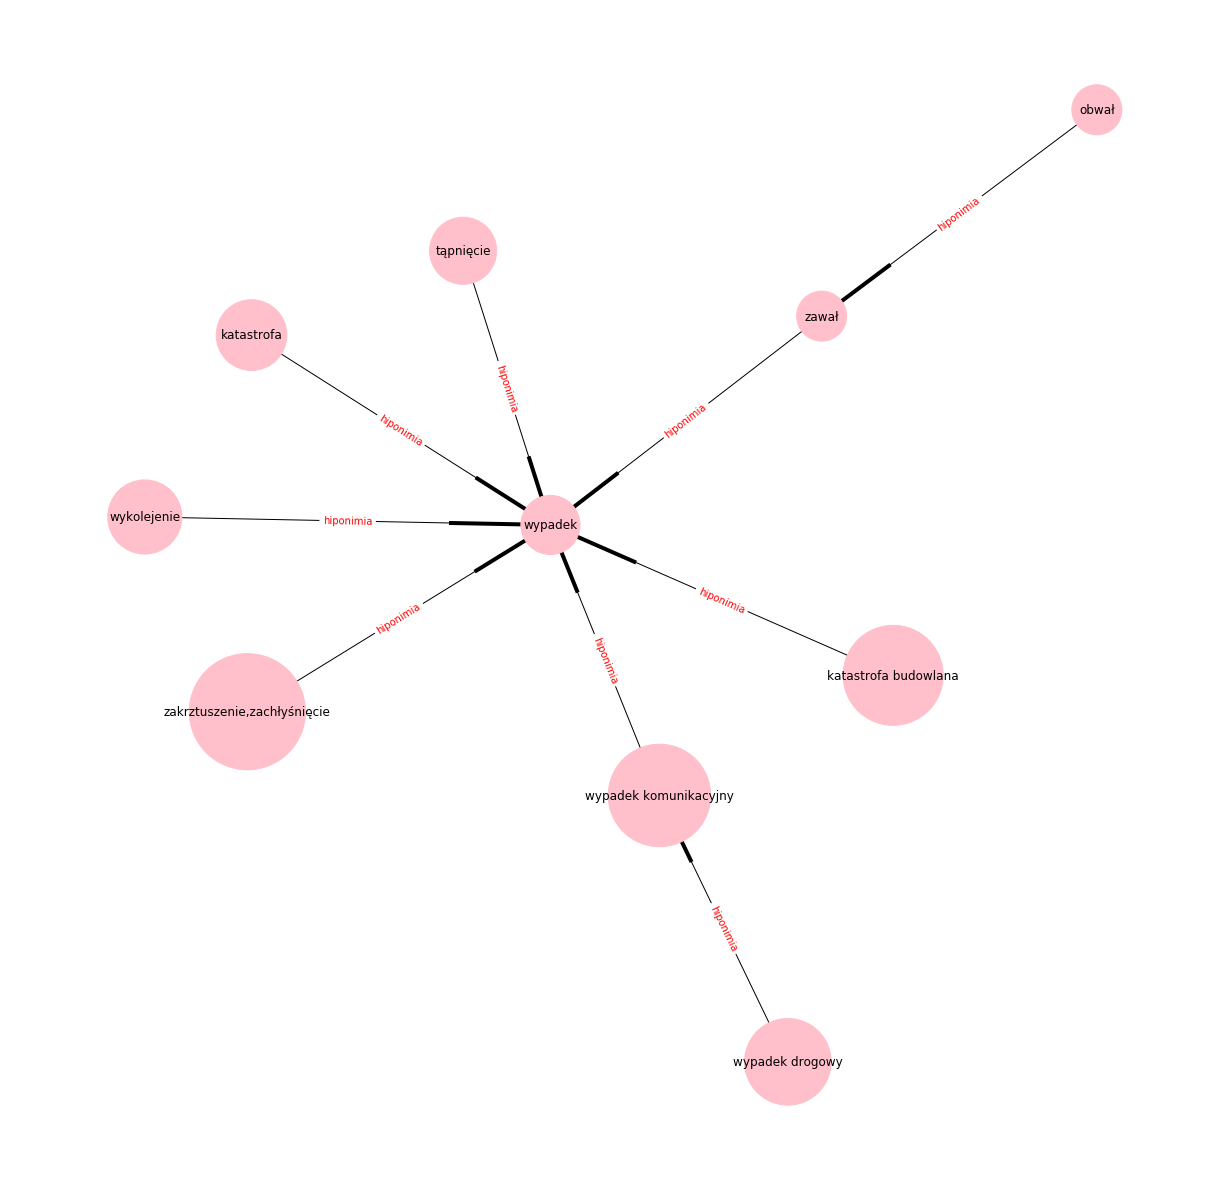

In [266]:
def zad_4():
    edges=[]
    edgesLabels={}
    senses = search_senses("wypadek", "noun")
    meaning = sense_meaning(senses, 1)
    sysnet = sysnet_from_sense(meaning)
    add_hyponyms(sysnet, edges, edgesLabels,2,1)
    show_graph(edges, edgesLabels)
zad_4()

### Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:
   1. szkoda<sub>2</sub>, strata<sub>1</sub>, uszczerbek<sub>1</sub>, szkoda majątkowa<sub>1</sub>, 
      uszczerbek na zdrowiu<sub>1</sub>, krzywda<sub>1</sub>, niesprawiedliwość<sub>1</sub>, nieszczęście<sub>2</sub>.
   1. wypadek<sub>1</sub>, wypadek komunikacyjny<sub>1</sub>, kolizja<sub>2</sub>, zderzenie<sub>2</sub>,
      kolizja drogowa<sub>1</sub>, bezkolizyjny<sub>2</sub>, katastrofa budowlana<sub>1</sub>, wypadek
      drogowy<sub>1</sub>.

Could not find meaning for szkoda majątkowa
krzywda,niesprawiedliwość -> nieszczęście,niedola [hiponimia]
strata,utrata,szkoda,uszczerbek -> uszczerbek na zdrowiu [hiperonimia]
krzywda,niesprawiedliwość -> strata,utrata,szkoda,uszczerbek [hiponimia]
uszczerbek na zdrowiu -> strata,utrata,szkoda,uszczerbek [hiponimia]
strata,utrata,szkoda,uszczerbek -> krzywda,niesprawiedliwość [hiperonimia]
nieszczęście,niedola -> krzywda,niesprawiedliwość [hiperonimia]


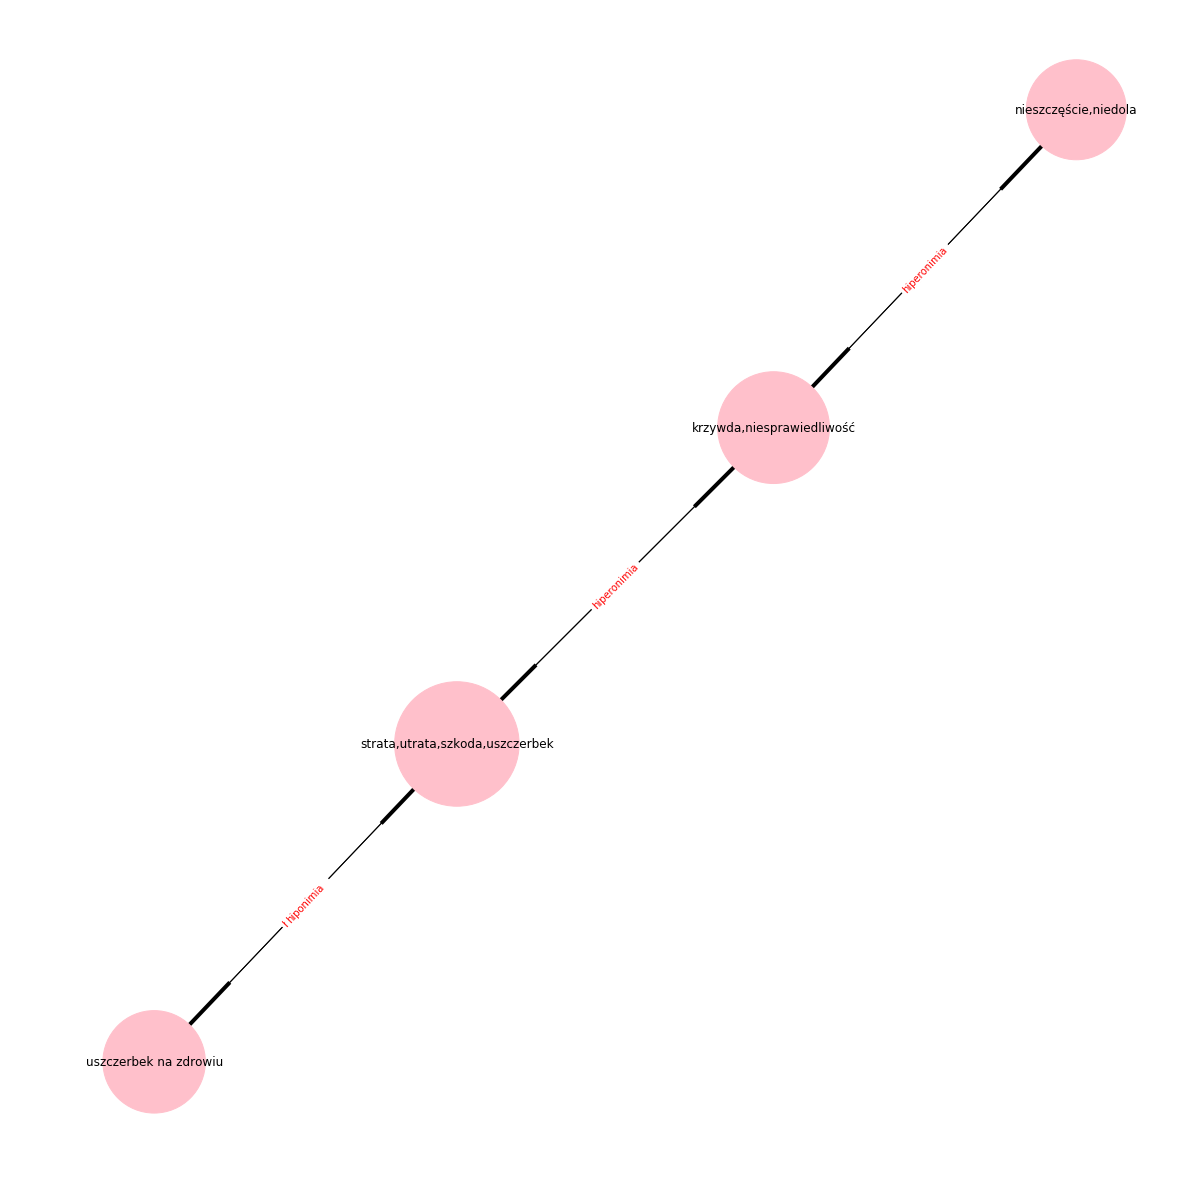

In [290]:
def draw_semantic_relations(group):
    sysnet_set = set()
    sysnet_dict = {}
    sysnet_name_dict = {}
    for (word,number) in group:
        senses = search_senses(word)
        meaning = sense_meaning(senses, number)
        if meaning is None:
            print('Could not find meaning for {}'.format(word))
        else:
            sysnet = sysnet_from_sense(meaning)
            sysnet_set.add(sysnet["id"])
            sysnet_dict[sysnet["id"]] = sysnet
    edges=[]
    edgesLabels={}
    for sysnet_id in sysnet_set:
        sysnet = sysnet_dict[sysnet_id]
        name = ",".join(map(lambda sense: sense['lemma']['word'], senses_from_sysnet(sysnet)))
        sysnet_name_dict[sysnet_id] = name
    for sysnet_id in sysnet_set:
        sysnet = sysnet_dict[sysnet_id]
        relations = sysnet_relations_to(sysnet)
        for relation in relations:
            from_synset_id = relation['synsetFrom']["id"]
            to_synset_id = relation['synsetTo']["id"]
            if from_synset_id in sysnet_set and to_synset_id in sysnet_set:
                from_name = sysnet_name_dict[from_synset_id]
                to_name = sysnet_name_dict[to_synset_id]
                relation_name = relation['relation']['name']
                print('{} -> {} [{}]'.format(from_name, to_name, relation_name))
                edges.append([from_name, to_name])
                edgesLabels[(from_name, to_name)] = relation_name
    show_graph(edges, edgesLabels)
    
def zad_5_1():
    group1 = [["szkoda", 2], ["strata", 1], ["uszczerbek", 1], ["szkoda majątkowa", 1], ["uszczerbek na zdrowiu", 1], ["krzywda", 1], ["niesprawiedliwość", 1], ["nieszczęście", 2]]
#     group2 = [["wypadek", 1], ["wypadek komunikacyjny", 1], ["kolizja", 2], ["zderzenie", 2], ["kolizja drogowa", 1], ["bezkolizyjny", 2], ["katastrofa budowlana", 1], ["wypadek drogowy", 1]]
    draw_semantic_relations(group1)
#     draw_semantic_relations(group2)
zad_5_1()

wypadek -> katastrofa budowlana [hiperonimia]
wypadek komunikacyjny -> wypadek [hiponimia]
katastrofa budowlana -> wypadek [hiponimia]
wypadek -> wypadek komunikacyjny [hiperonimia]
wypadek drogowy -> wypadek komunikacyjny [hiponimia]
wypadek komunikacyjny -> wypadek drogowy [hiperonimia]


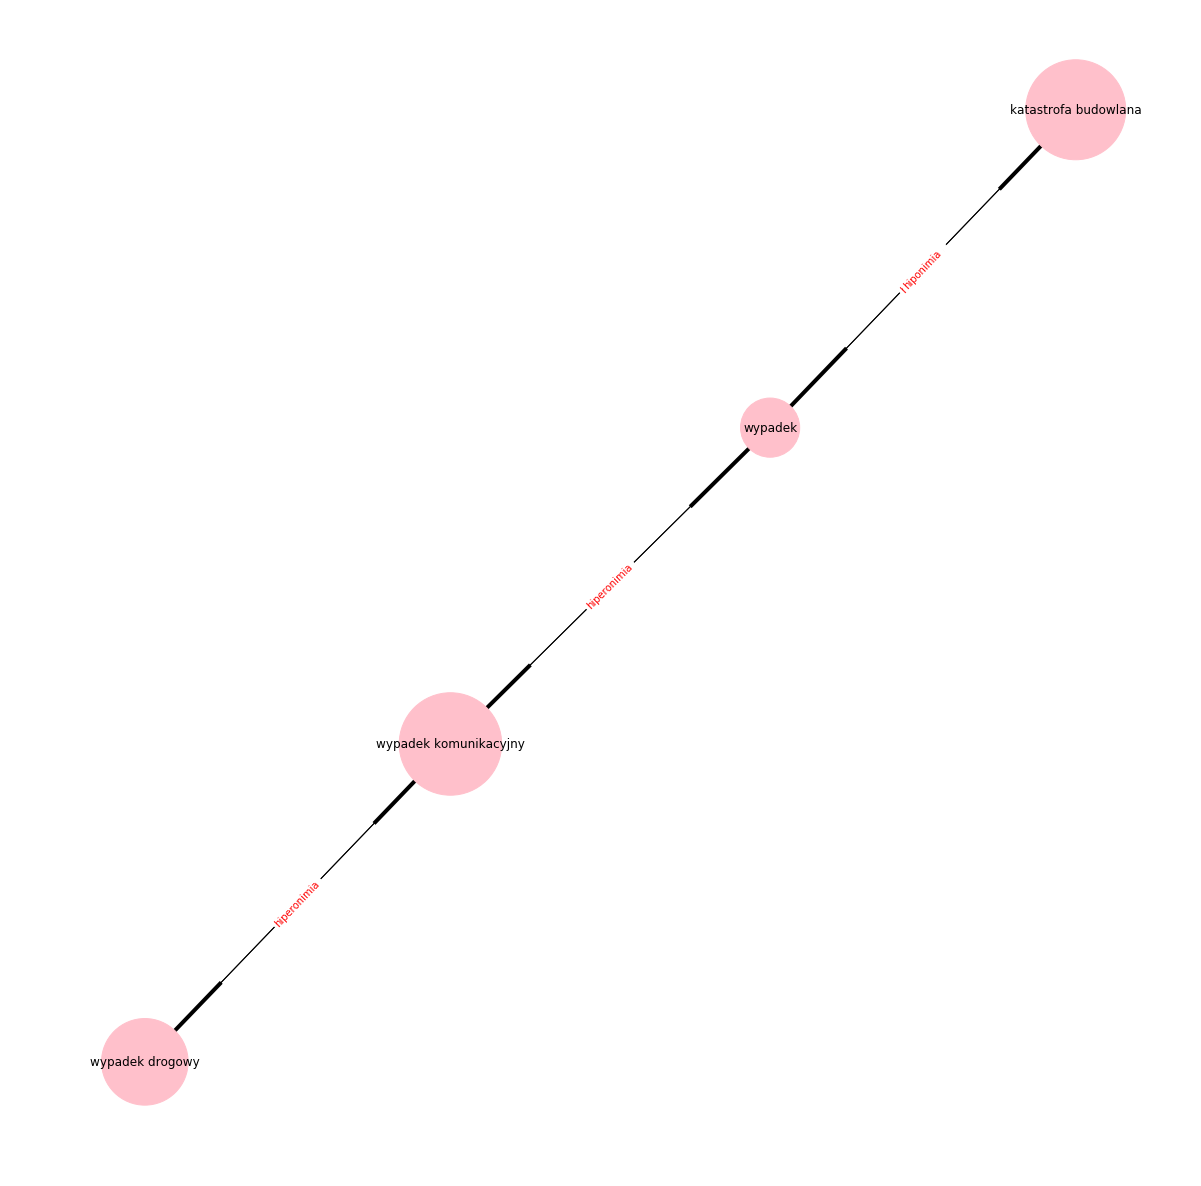

In [297]:
def zad_5_2():
#     group1 = [["szkoda", 2], ["strata", 1], ["uszczerbek", 1], ["szkoda majątkowa", 1], ["uszczerbek na zdrowiu", 1], ["krzywda", 1], ["niesprawiedliwość", 1], ["nieszczęście", 2]]
    group2 = [["wypadek", 1], ["wypadek komunikacyjny", 1], ["kolizja", 2], ["zderzenie", 2], ["kolizja drogowa", 1], ["bezkolizyjny", 2], ["katastrofa budowlana", 1], ["wypadek drogowy", 1]]
#     draw_semantic_relations(group1)
    draw_semantic_relations(group2)
zad_5_2()

### Find the value of [Leacock-Chodorow semantic similarity measure](ftp://www-vhost.cs.toronto.edu/public_html/public_html/pub/gh/Budanitsky+Hirst-2001.pdf) between following pairs of lexemes:
   1. szkoda<sub>2</sub> - wypadek<sub>1</sub>,
   1. kolizja<sub>2</sub> - szkoda majątkowa<sub>1</sub>,
   1. nieszczęście<sub>2</sub> - katastrofa budowlana<sub>1</sub>.

In [51]:
def zad_6():
    return None
zad_6()

## Hints

1. WordNet is a semantic dictionary that has the following features:
   1. it identifies **the meanings** of the words, i.e. _zamek_ in the sense of a _castle_ and _zamek_ in the sense of a  _tool_ have two distinct representations,
   1. it describes these meaning using **semantic relations**, e.g. _zamek<sub>1</sub>_ is a **hyponym** of
      _budynek<sub>1</sub>_ and _zamek<sub>2</sub>_ is a **hypernym** of _zatrzasku<sub>2</sub>_.
1. The meaning of a lexeme is identified by an index, e.g. _zamek<sub>1</sub>_ identifies the first meaning and
   _zamek<sub>2</sub>_ the second, etc.
1. WordNet defines **lexemes** and **synsets**. The lexemes roughly correspond to words, i.e. we say that a lexeme with
   an index _has_ a particular meaning, e.g.  _zamek<sub>2</sub>_  refers to a tool for closing things.
   But that meaning is obtained thanks to its participation to a particular _synset_. A synset is a set of lexemes that
   share meaning. E.g. _szkoda<sub>2</sub>_, _uszczerbek<sub>1</sub>_, _strata<sub>1</sub>_ and _utrata<sub>1</sub>_
   belong to one synset. As a consequence the definition and most of the relations are attached to a synset, rather than
   a lexeme. Lexemes belonging to a particular synset are called synonyms.
1. The [NLTK](https://www.nltk.org/) library has an [implementation](http://www.nltk.org/howto/wordnet.html) of Leacock-Chodorow measure, 
   but it does not integrate with the Polish WordNet.
1. The [pywnxml](https://github.com/ppke-nlpg/pywnxml) library allows for reading the Polish WordNet, but it lacks that
   measure.
1. The contents of the Polish WordNet may also be accessed by a [web API](http://api.slowosiec.clarin-pl.eu/docs/index.html)